In [1]:
# %cd drive/My\ Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


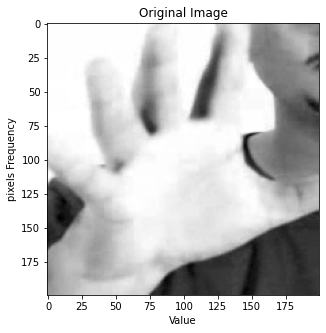

(array([[  6.,  12.,  19., ...,   6.,   9., 103.],
        [  0.,  17.,  22., ...,   7.,  10., 100.],
        [  0.,  16.,  25., ...,   5.,  11.,  99.],
        ...,
        [  2.,  23.,  58., ...,  16.,   0.,   0.],
        [  1.,  23.,  60., ...,  17.,   0.,   0.],
        [  1.,  24.,  61., ...,  18.,   0.,   0.]]),
 array([ 36. ,  57.9,  79.8, 101.7, 123.6, 145.5, 167.4, 189.3, 211.2,
        233.1, 255. ]),
 <a list of 200 Lists of Patches objects>)

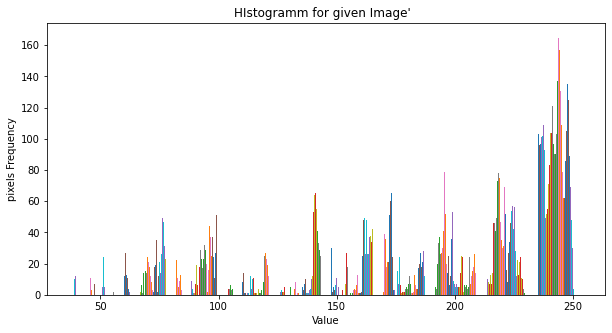

In [ ]:
import cv2
img = cv2.imread('/content/drive/MyDrive/Hands Single Frames/Train/bad/s0002 (12).jpg')
#important library to show the image 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
#importing numpy to work with large set of data.
import numpy as np
#image read function
#image sclicing into 2D. 
x=img[:,:,0]
# x co-ordinate denotation. 
plt.xlabel("Value")
# y co-ordinate denotation.
plt.ylabel("pixels Frequency")
# title of an image .
plt.title("Original Image")
# imshow function with comperision of gray level value.
plt.imshow(x,cmap="gray")
#plot the image on a plane.
plt.show()
plt.figure(figsize=(10,5))
plt.title("HIstogramm for given Image'  ")
plt.xlabel("Value")
plt.ylabel("pixels Frequency")
#hist function is used to plot the histogram of an image.
plt.hist(x)

In [ ]:
import random
import re
from pathlib import Path
from skimage.io import imread

In [ ]:
def show_images(images, size=3):
    figsize = (size * len(images), size)
    _, ax = plt.subplots(1, len(images), squeeze=False, figsize=figsize)
    for i, image in enumerate(images):
        ax[0, i].imshow(image)

In [ ]:
def show_histogram_images(images, size=3):
    figsize = (size * len(images), size)
    _, ax = plt.subplots(1, len(images), squeeze=False, figsize=figsize)
    for i, image in enumerate(images):
        #image sclicing into 2D. 
        x=image[:,:,0]
        ax[0, i].hist(x)

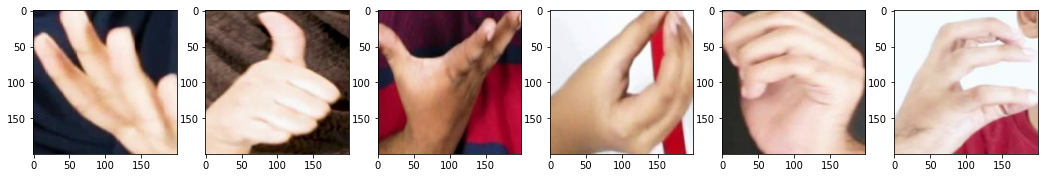

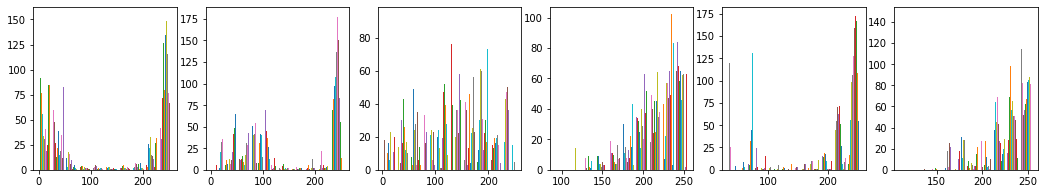

In [ ]:
images_list = ['/content/drive/MyDrive/Hands Single Frames/Train/bad/s0009 (12).jpg','/content/drive/MyDrive/Hands Single Frames/Train/best/s0008 (13).jpg',
          '/content/drive/MyDrive/Hands Single Frames/Train/glad/s0006 (14).jpg','/content/drive/MyDrive/Hands Single Frames/Train/sad/s0017 (18).jpg',
          '/content/drive/MyDrive/Hands Single Frames/Train/scared/s0005 (6).jpg','/content/drive/MyDrive/Hands Single Frames/Train/stiff/s0002 (13).jpg']
# print("ORIGINAL IMAGES")
show_images([imread(images_list[i]) for i in range(len(images_list))])
# print("\nHISTOGRAM OF ABOVE IMAGES")
show_histogram_images([imread(images_list[i]) for i in range(len(images_list))])

In [ ]:
import keras
from keras.models import Model
from keras.layers import Dense
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

In [ ]:
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory="/content/drive/MyDrive/Hands Single Frames/Train",target_size=(224,224))
tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory="/content/drive/MyDrive/Hands Single Frames/Test", target_size=(224,224))

Found 350 images belonging to 7 classes.
Found 105 images belonging to 7 classes.


In [ ]:
from keras.applications.vgg16 import VGG16
vggmodel = VGG16(weights='imagenet', include_top=True)

In [ ]:
vggmodel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
for layers in (vggmodel.layers)[:19]:
    print(layers)
    layers.trainable = False

In [ ]:
X= vggmodel.layers[-2].output
predictions = Dense(7, activation="softmax")(X)
model_final = Model(inputs = vggmodel.input, outputs = predictions)

In [ ]:
from tensorflow.keras import optimizers
import sklearn.metrics as metrics
from keras import backend as K
from sklearn.metrics import roc_auc_score
import numpy as np
import tensorflow as tf

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def AUC(y_true, y_pred):   
    ptas = tf.stack([binary_PTA(y_true,y_pred,k) for k in np.linspace(0, 1, 1000)],axis=0)
    pfas = tf.stack([binary_PFA(y_true,y_pred,k) for k in np.linspace(0, 1, 1000)],axis=0)
    pfas = tf.concat([tf.ones((1,)) ,pfas],axis=0)
    binSizes = -(pfas[1:]-pfas[:-1])
    s = ptas*binSizes
    return K.sum(s, axis=0)

# P_TA prob true alerts for binary classifier
def binary_PTA(y_true, y_pred, threshold=K.variable(value=0.5)):
    y_pred = K.cast(y_pred >= threshold, 'float32')
    # P = total number of positive labels
    P = K.sum(y_true)
    # TP = total number of correct alerts, alerts from the positive class labels
    TP = K.sum(y_pred * y_true)
    return TP / (P + 1)

# PFA, prob false alert for binary classifier
def binary_PFA(y_true, y_pred, threshold=K.variable(value=0.5)):
    y_pred = K.cast(y_pred >= threshold, 'float32')
    # N = total number of negative labels
    N = K.sum(1 - y_true)
    # FP = total number of false alerts, alerts from the negative class labels
    FP = K.sum(y_pred - y_pred * y_true)
    return FP / (N + 1)


In [ ]:
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(learning_rate=0.0001, momentum=0.9), metrics=['accuracy',f1_m,precision_m, recall_m, AUC])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

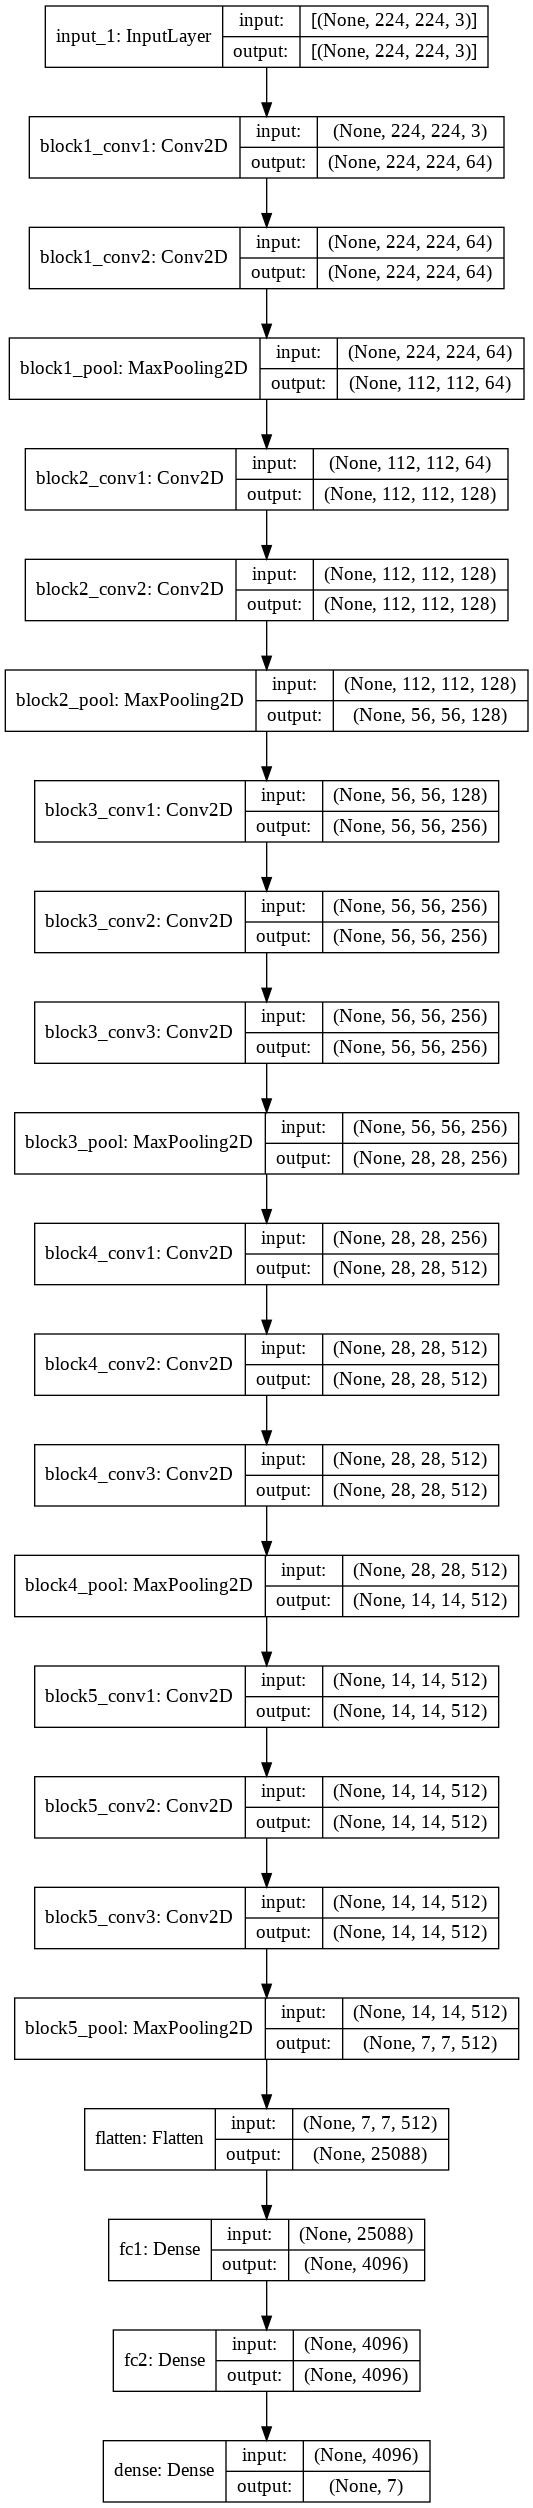

In [ ]:
model_final.summary()
from keras.utils.vis_utils import plot_model
plot_model(model_final, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
NUM_EPOCHS = 50


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# simple early stopping
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
# mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)


checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
#model_final.fit(traindata, steps_per_epoch= 2, epochs= 100, validation_data= testdata, validation_steps=1, callbacks=[checkpoint,early])
history = model_final.fit(traindata, epochs=25,validation_data=testdata, callbacks=[checkpoint,early], steps_per_epoch=2)
# model_final.save_weights("/content/drive/MyDrive/Hands Single Frames/best_model.h5")

Epoch 1/25
2/2 [==============================] - 175s 105s/step - loss: 2.9117 - accuracy: 0.1290 - f1_m: 0.0634 - precision_m: 0.0938 - recall_m: 0.0479 - AUC: 0.4856 - val_loss: 2.4920 - val_accuracy: 0.1238 - val_f1_m: 0.0489 - val_precision_m: 0.1167 - val_recall_m: 0.0312 - val_AUC: 0.5172
Epoch 2/25
2/2 [==============================] - 92s 70s/step - loss: 2.3976 - accuracy: 0.2188 - f1_m: 0.1196 - precision_m: 0.2556 - recall_m: 0.0781 - AUC: 0.5634 - val_loss: 1.8596 - val_accuracy: 0.3143 - val_f1_m: 0.2163 - val_precision_m: 0.4564 - val_recall_m: 0.1450 - val_AUC: 0.6534
Epoch 3/25
2/2 [==============================] - 91s 70s/step - loss: 1.8863 - accuracy: 0.3750 - f1_m: 0.2642 - precision_m: 0.5722 - recall_m: 0.1719 - AUC: 0.6788 - val_loss: 1.4329 - val_accuracy: 0.4667 - val_f1_m: 0.3982 - val_precision_m: 0.6818 - val_recall_m: 0.2821 - val_AUC: 0.7717
Epoch 4/25
2/2 [==============================] - 91s 71s/step - loss: 1.4613 - accuracy: 0.5312 - f1_m: 0.4568 -

In [ ]:
# from keras.models import load_model
# # load the saved model
# saved_model = load_model('vgg16_1.h5')
# # evaluate the model
# _, train_acc = saved_model.evaluate(traindata)
# _, test_acc = saved_model.evaluate(testdata)
# print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

In [ ]:
# score=model_final.evaluate(testdata)
# print(score)

4/4 [==============================] - 54s 12s/step - loss: 0.0221 - accuracy: 1.0000 - f1_m: 0.9960 - precision_m: 1.0000 - recall_m: 0.9922 - AUC: 0.9523
[0.022083748131990433, 1.0, 0.9960317611694336, 1.0, 0.9921875, 0.9522727727890015]


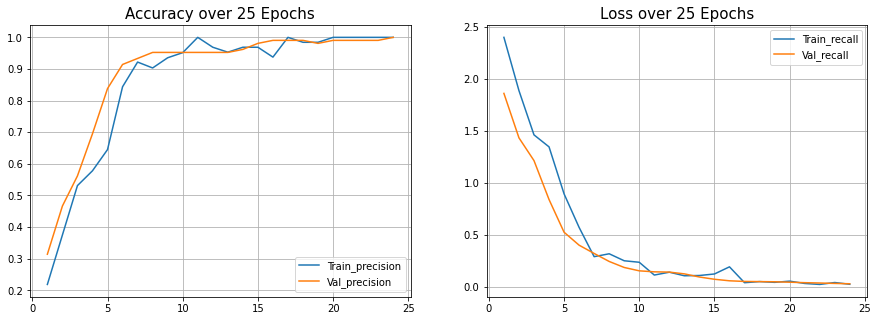

In [ ]:
#Plot the accuracy and loss graphs

import matplotlib.pyplot as plt

def plot_acc_loss(result, epochs):
    acc = result.history['accuracy']
    loss = result.history['loss']
    val_acc = result.history['val_accuracy']
    val_loss = result.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(1,epochs), acc[1:], label='Train_precision')
    plt.plot(range(1,epochs), val_acc[1:], label='Val_precision')
    plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1,epochs), loss[1:], label='Train_recall')
    plt.plot(range(1,epochs), val_loss[1:], label='Val_recall')
    plt.title('Loss over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_acc_loss(history, 25)

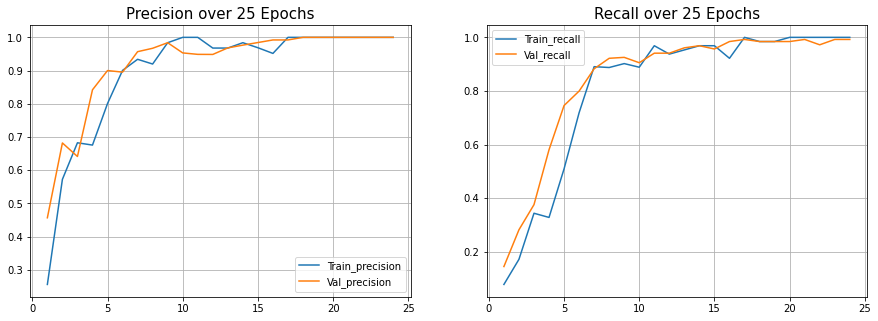

In [ ]:
#Plot the accuracy and loss graphs

import matplotlib.pyplot as plt

def plot_prec_rec(result, epochs):
    prec = result.history['precision_m']
    recall = result.history['recall_m']
    val_prec = result.history['val_precision_m']
    val_recall = result.history['val_recall_m']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(1,epochs), prec[1:], label='Train_precision')
    plt.plot(range(1,epochs), val_prec[1:], label='Val_precision')
    plt.title('Precision over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1,epochs), recall[1:], label='Train_recall')
    plt.plot(range(1,epochs), val_recall[1:], label='Val_recall')
    plt.title('Recall over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_prec_rec(history, 25)

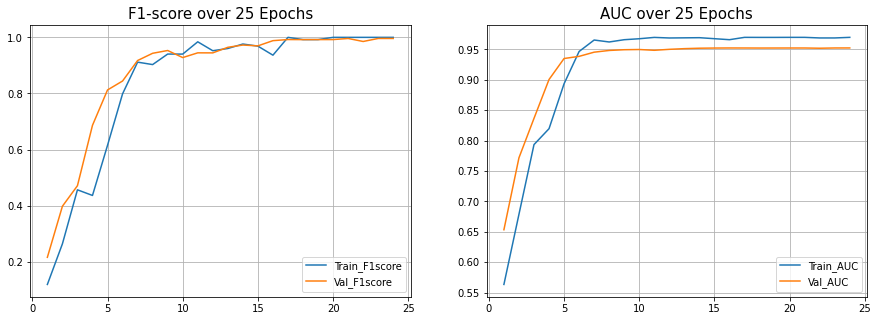

In [ ]:
#Plot the accuracy and loss graphs

import matplotlib.pyplot as plt

def plot_f1_auc(result, epochs):
    f1 = result.history['f1_m']
    auc = result.history['AUC']
    val_f1 = result.history['val_f1_m']
    val_auc = result.history['val_AUC']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(1,epochs), f1[1:], label='Train_F1score')
    plt.plot(range(1,epochs), val_f1[1:], label='Val_F1score')
    plt.title('F1-score over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1,epochs), auc[1:], label='Train_AUC')
    plt.plot(range(1,epochs), val_auc[1:], label='Val_AUC')
    plt.title('AUC over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_f1_auc(history,25)

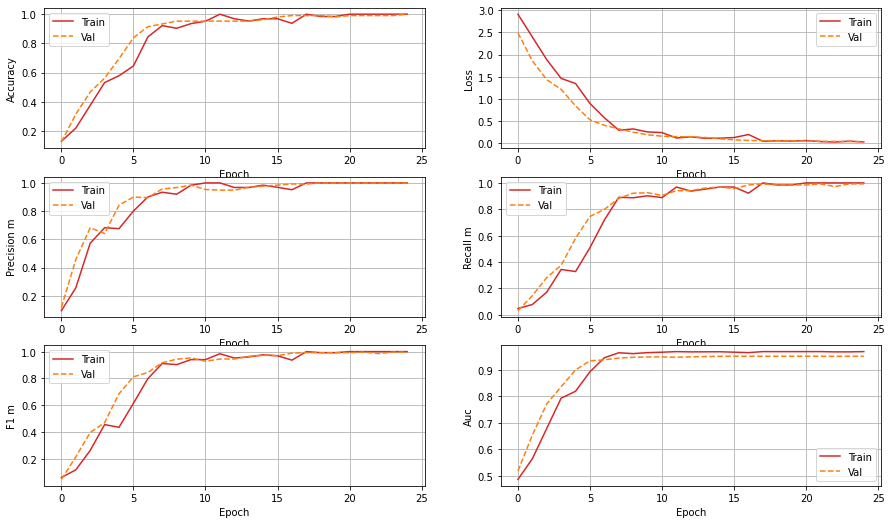

<Figure size 1080x1080 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (15, 15)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
    metrics =  ['accuracy','loss','precision_m', 'recall_m','f1_m','AUC']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(5, 2, n+1)  # adjust according to metrics
        plt.plot(history.epoch,  history.history[metric], color=colors[3], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[1], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.legend()
        plt.grid(True)
    plt.show()
    
    plt.savefig('OverallGraphs')
    

plot_metrics(history)

In [ ]:
import glob
classes = ['bad','best','glad','sad','scared','stiff','surprise']
listt = []
for i in classes:
  file_path = f"/content/drive/MyDrive/Hands Single Frames/Test/{i}"
  file_list = glob.glob(f"{file_path}/*.jpg")
  listt.append(file_list)
  print(f"There are {len(file_list)} files in {i} folder")
final_list = []  
for i in listt:
  for j in i:
    final_list.append(j)
    
y_prediction = []
for images in final_list:
    img = image.load_img(images,target_size=(224,224))
    img_ = np.asarray(img)
    img = np.expand_dims(img_, axis=0)
    output = model_final.predict(img)
    x=np.argmax(output, axis = 1)
    y_prediction.append(int(x))
print("done!")

There are 15 files in bad folder
There are 15 files in best folder
There are 15 files in glad folder
There are 15 files in sad folder
There are 15 files in scared folder
There are 15 files in stiff folder
There are 15 files in surprise folder
done!


Confusion Matrix
[[15  0  0  0  0  0  0]
 [ 0 15  0  0  0  0  0]
 [ 0  0 15  0  0  0  0]
 [ 0  0  0 15  0  0  0]
 [ 0  0  0  0 15  0  0]
 [ 0  0  0  0  0 15  0]
 [ 0  0  0  0  0  0 15]]


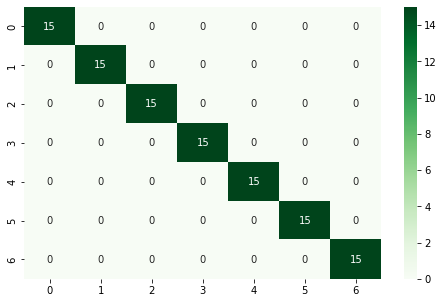

In [ ]:
#Confution Matrix on validation dataset
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as  sns
print('Confusion Matrix')
cm  = confusion_matrix(testdata.classes, y_prediction)
print(cm)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,cmap="Greens")
plt.show()

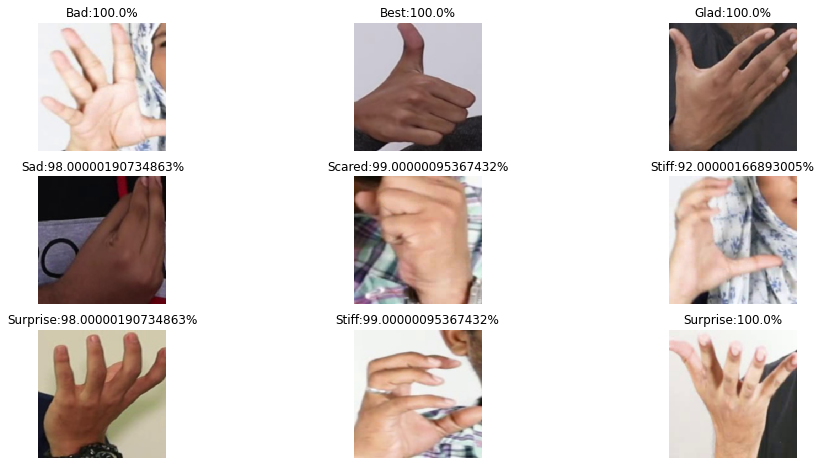

In [ ]:
images = ['/content/drive/MyDrive/Hands Single Frames/Test/bad/s0016 (13).jpg','/content/drive/MyDrive/Hands Single Frames/Test/best/s0292 (19).jpg',
          '/content/drive/MyDrive/Hands Single Frames/Test/glad/s0281 (15).jpg','/content/drive/MyDrive/Hands Single Frames/Test/sad/s0268 (13).jpg',
          '/content/drive/MyDrive/Hands Single Frames/Test/scared/s0014 (6).jpg','/content/drive/MyDrive/Hands Single Frames/Test/stiff/s0016 (9).jpg',
         '/content/drive/MyDrive/Hands Single Frames/Test/surprise/s0260 (6).jpg', '/content/drive/MyDrive/Hands Single Frames/Train/stiff/s0014 (11).jpg',
          '/content/drive/MyDrive/Hands Single Frames/Train/surprise/s0005 (14).jpg']

plt.figure(figsize=(16, 8)) 
for i in range(len(images)):
  img = image.load_img(images[i],target_size=(224,224))
  img_ = np.asarray(img)
  img = np.expand_dims(img_, axis=0)
  output = model_final.predict(img)
  s = ""
  # print(output[0])
  if output[0][0] > output[0][1] and output[0][0] > output[0][2] and output[0][0] > output[0][3] and output[0][0] > output[0][4] and output[0][0] > output[0][5] and output[0][0] > output[0][6]:
    s = f"Bad:{round(np.max(output[0]),2)*100}%"
    # print("Bad")
  elif output[0][1] > output[0][0] and output[0][1] > output[0][2] and output[0][1] > output[0][3] and output[0][1] > output[0][4] and output[0][1] > output[0][5] and output[0][1] > output[0][6]:
    # print('BEst')
    s = f"Best:{round(np.max(output[0]),2)*100}%"
  elif output[0][2] > output[0][0] and output[0][2] > output[0][1] and output[0][2] > output[0][3] and output[0][2] > output[0][4] and output[0][2] > output[0][5] and output[0][2] > output[0][6]:
    # print('Glad')
    s = f"Glad:{round(np.max(output[0]),2)*100}%"
  elif output[0][3] > output[0][0] and output[0][3] > output[0][1] and output[0][3] > output[0][2] and output[0][3] > output[0][4] and output[0][3] > output[0][5] and output[0][3] > output[0][6]:
    # print('Sad')
    s = f"Sad:{round(np.max(output[0]),2)*100}%"
  elif output[0][4] > output[0][0] and output[0][4] > output[0][1] and output[0][4] > output[0][2] and output[0][4] > output[0][3] and output[0][4] > output[0][5] and output[0][4] > output[0][6]:
    # print('Scared')
    s = f"Scared:{round(np.max(output[0]),2)*100}%"
  elif output[0][5] > output[0][0] and output[0][5] > output[0][1] and output[0][5] > output[0][2] and output[0][5] > output[0][3] and output[0][5] > output[0][6] and output[0][5] > output[0][6]:
    # print('Stiff')
    s = f"Stiff:{round(np.max(output[0]),2)*100}%"
  elif output[0][6] > output[0][0] and output[0][6] > output[0][1] and output[0][6] > output[0][2] and output[0][6] > output[0][3] and output[0][6] > output[0][4]  and output[0][6] > output[0][5]:
    s = f"Surprise:{round(np.max(output[0]),2)*100}%"
    # print('Surprise')
  plt.subplot(3, 3,1+i)
  plt.imshow(img_)
  plt.title(s)
  plt.axis('off')
  # plt.suptitle('Face Recognition through VGG-16')

# **Saving a Model**

In [ ]:
# serialize model to JSON
from keras.models import model_from_json
model_json = model_final.to_json()
with open("/content/drive/MyDrive/HandsSignRecognitionKerasFileModel/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_final.save_weights("/content/drive/MyDrive/HandsSignRecognitionKerasFileModel/model.h5")
print("Saved model to disk")
 

Saved model to disk


# **Loading a Model**

In [ ]:
# load json and create model
from keras.models import model_from_json
json_file = open('/content/drive/MyDrive/HandsSignRecognitionKerasFileModel/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/HandsSignRecognitionKerasFileModel/model.h5")
print("Loaded model from disk")

Loaded model from disk


# **Prediction on Single Frame From Loaded Model**

stiff


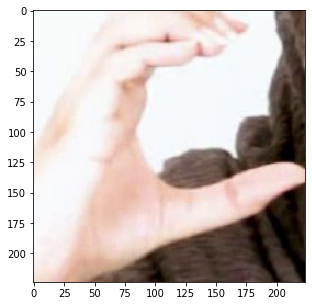

In [ ]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

classes = ['bad','best','glad','sad','scared','stiff','surprise']

img = image.load_img("/content/drive/MyDrive/Hands Single Frames/Train/stiff/s0008 (9).jpg",target_size=(224,224))
img_ = np.asarray(img)
plt.figure(figsize=(8,5))
plt.imshow(img)
img = np.expand_dims(img_, axis=0)
output = loaded_model.predict(img)
x=np.argmax(output, axis = 1)
print(classes[int(x)])

# **Testing on Videos**

In [34]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
from keras.models import model_from_json
from keras.preprocessing import image
from collections import deque

import matplotlib.pyplot as plt

Loaded model from disk


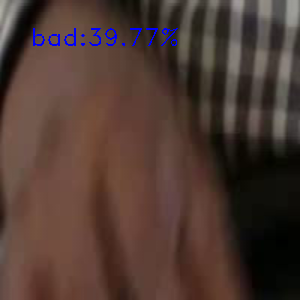

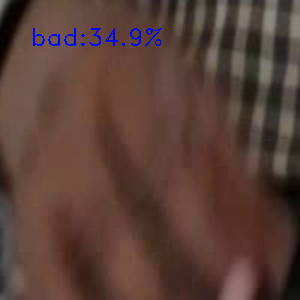

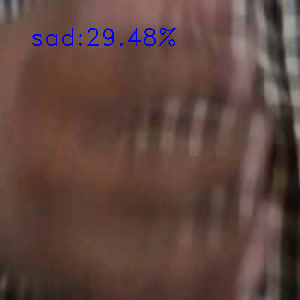

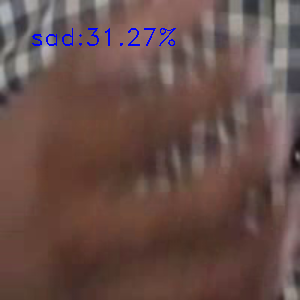

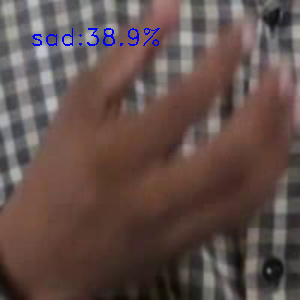

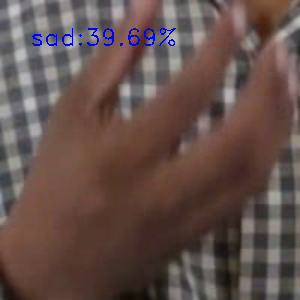

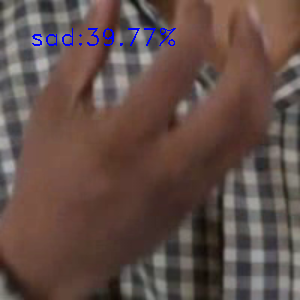

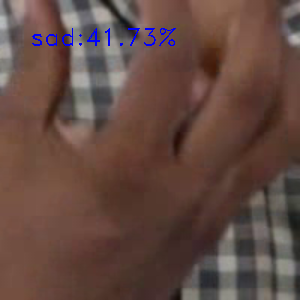

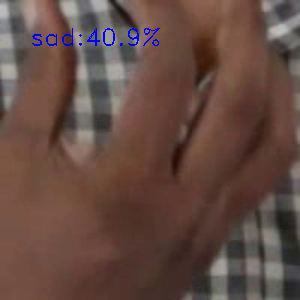

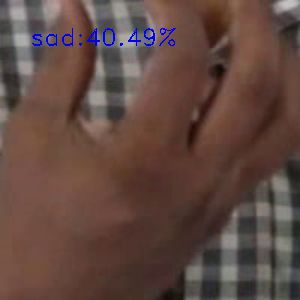

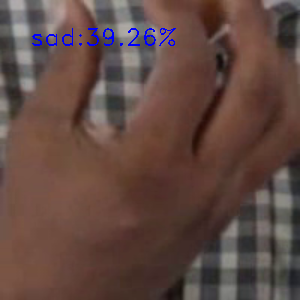

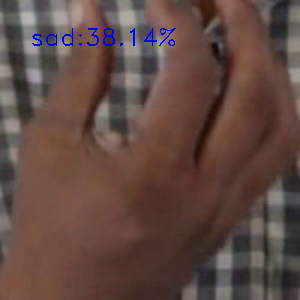

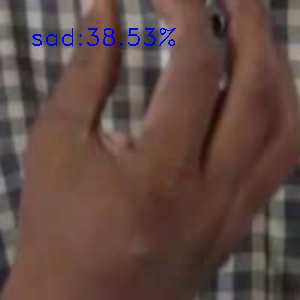

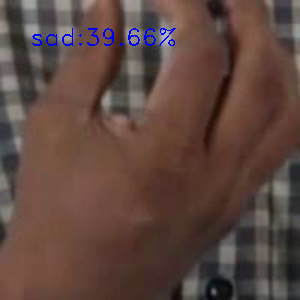

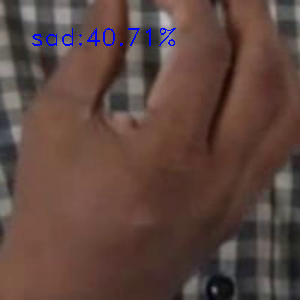

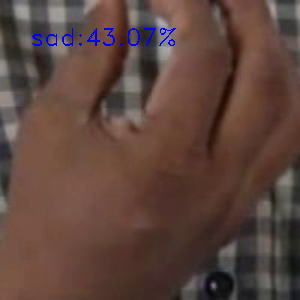

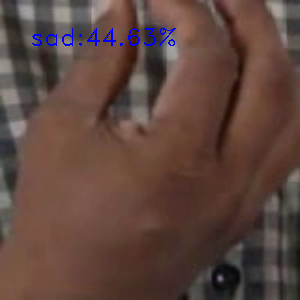

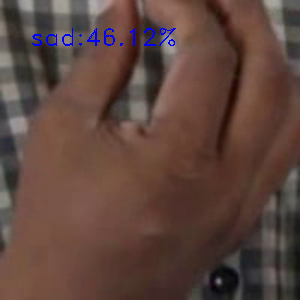

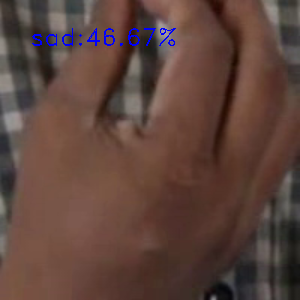

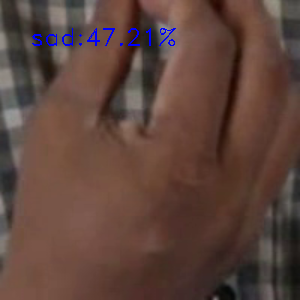

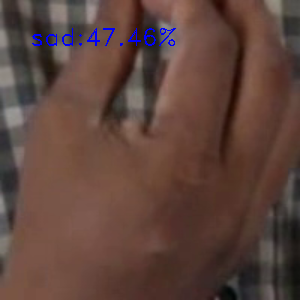

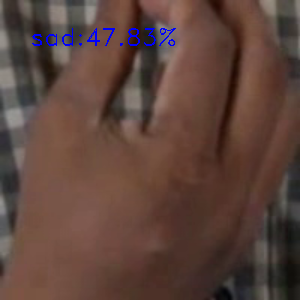

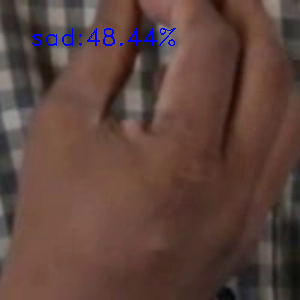

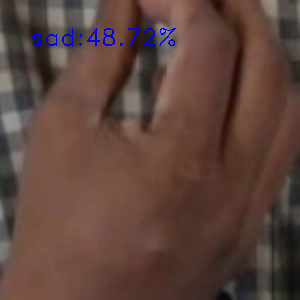

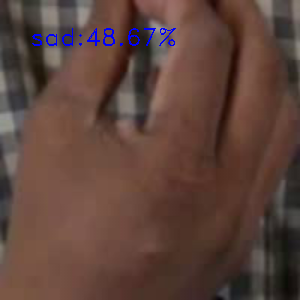

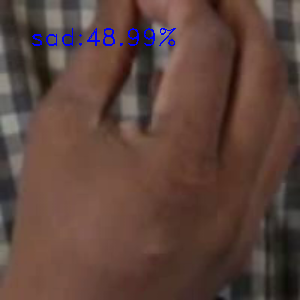

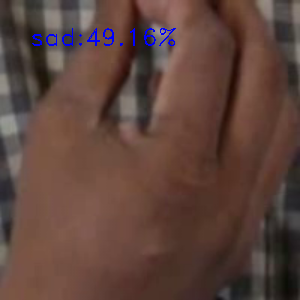

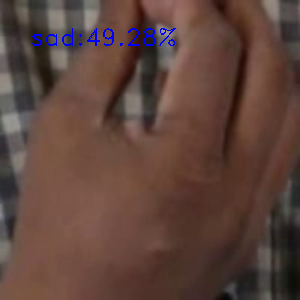

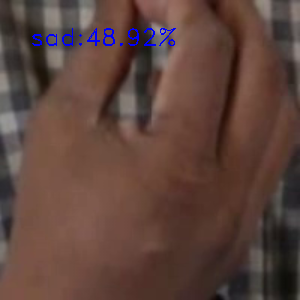

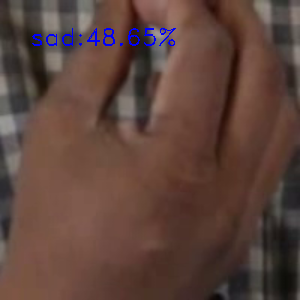

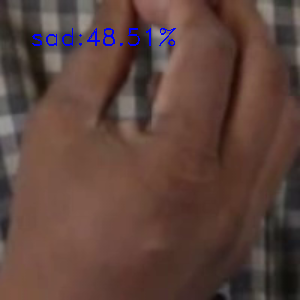

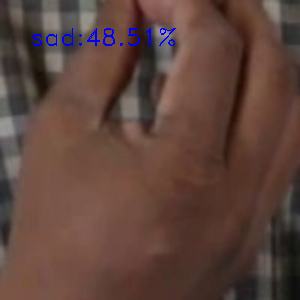

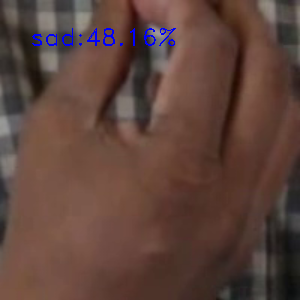

Finalizing...


In [33]:
# load json and create model
json_file = open('/content/drive/MyDrive/HandsSignRecognitionKerasFileModel/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/HandsSignRecognitionKerasFileModel/model.h5")
print("Loaded model from disk")
classes = ['bad','best','glad','sad','scared','stiff','surprise']

mean = np.array([123.68,116.779,103.939][::1], dtype='float32')
Queue = deque(maxlen=128)

path = "/content/drive/MyDrive/ROI Hands Videos/roi_hand_adjectives/sad/s0033.mp4"
video_capture = cv2.VideoCapture(path)

# video_capture = cv2.VideoCapture(0)
writer = None
(Width,Height) = (None,None)
while (video_capture.isOpened()):
    (taken, frame) = video_capture.read()
    if not taken:
        break
    if Width is None or Height is None:
        (Width,Height) = frame.shape[:2]

    output = frame.copy()
    output = cv2.resize(output, (300 ,300))
    # print(output.shape)
    # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    frame = cv2.resize(frame, (224,224)).astype('float32')
    frame -=mean
    preds = loaded_model.predict(np.expand_dims(frame, axis=0))[0]
    Queue.append(preds)
    results = np.array(Queue).mean(axis=0)
    prec = round(np.max(results), 2) * 100

    i=np.argmax(results)
    label = classes[int(i)]
    # print(label)

    cv2.putText(output, label+":"+str(round(results[int(i)]*100,2))+"%", (30, 45), cv2.FONT_HERSHEY_DUPLEX, 0.8, (255, 0, 0))

    if writer is None:
        fourcee = cv2.VideoWriter_fourcc(*'XVID')
        writer = cv2.VideoWriter(f'/content/drive/MyDrive/HandsSignRecognitionKerasFileModel/outputVideos/{path.split("/")[-1].split(".")[0]}.avi', fourcee, 5, (300,300), True)

    writer.write(output)
    cv2_imshow(output)
    # cv2.imshow("In Progress...",output)

    key = cv2.waitKey(1) & 0xFF

print("Finalizing...")
writer.release()
video_capture.release()
cv2.destroyAllWindows()